## Model 1

5 workers, numnber of tasks ranges from 5 to 500

Academic license - for non-commercial use only
  0.045166 seconds (123 allocations: 64.469 KiB)
Academic license - for non-commercial use only
  0.052298 seconds (123 allocations: 213.750 KiB)
Academic license - for non-commercial use only
  0.164076 seconds (133 allocations: 459.172 KiB)
Academic license - for non-commercial use only
  0.244695 seconds (149 allocations: 1.737 MiB)
Academic license - for non-commercial use only
  0.808789 seconds (153 allocations: 4.784 MiB, 14.16% gc time)
Academic license - for non-commercial use only
  3.110300 seconds (154 allocations: 19.044 MiB, 0.45% gc time)
Academic license - for non-commercial use only
 13.395959 seconds (154 allocations: 42.793 MiB, 0.35% gc time)
Academic license - for non-commercial use only
 23.290435 seconds (154 allocations: 76.031 MiB, 1.31% gc time)


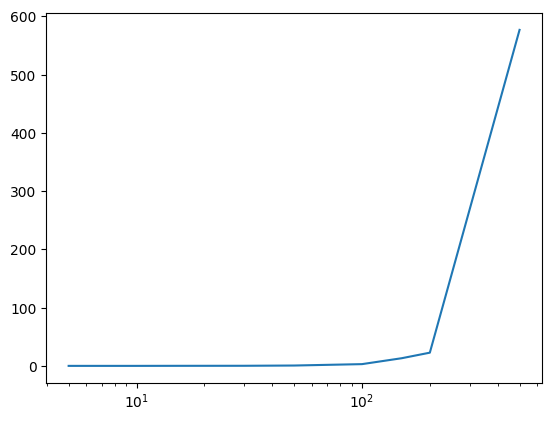

Academic license - for non-commercial use only
579.968473 seconds (161 allocations: 474.729 MiB, 0.35% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003F560470>

In [40]:
using JuMP, Gurobi, PyPlot

scaleFactor = [1 2 3 6 10 20 30 40 100]
    
timer = zeros(length(scaleFactor))

for i=1:length(scaleFactor)

    N = 100 #tasks
    M = 5*scaleFactor[i] #workers
    T = N #upper bound on project completion

    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    @time(solve(m))
    timer[i] = getsolvetime(m)

end

semilogx(scaleFactor,timer)

## Model 1

100 tasks, workers vary from 5 to 100


In [55]:
using JuMP, Gurobi, PyPlot

scaleFactor = [1 2 6 10 12 18 20]
    
timer = zeros(length(scaleFactor))

for i=1:length(scaleFactor)

    N = 100 #tasks
    M = 5*scaleFactor[i] #workers
    T = N #upper bound on project completion

    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    @time(solve(m))
    timer[i] = getsolvetime(m)

end

semilogx(scaleFactor,timer)

Academic license - for non-commercial use only
  2.520923 seconds (154 allocations: 19.044 MiB, 0.57% gc time)
Academic license - for non-commercial use only
  4.877439 seconds (154 allocations: 38.053 MiB, 1.21% gc time)
Academic license - for non-commercial use only
 20.061721 seconds (161 allocations: 114.090 MiB, 1.39% gc time)
Academic license - for non-commercial use only
 15.710448 seconds (163 allocations: 190.126 MiB, 2.28% gc time)
Academic license - for non-commercial use only
 29.327359 seconds (163 allocations: 228.145 MiB, 1.95% gc time)
Academic license - for non-commercial use only
 32.404461 seconds (163 allocations: 342.200 MiB, 4.14% gc time)
Academic license - for non-commercial use only
 24.172739 seconds (163 allocations: 380.218 MiB, 8.56% gc time)


LoadError: [91mBoundsError: attempt to access 1×7 Array{Int64,2} at index [8][39m

## Model 2 - Tasks 

Number of workers and task types held constant

Total number of tasks scales

Academic license - for non-commercial use only
  0.046824 seconds (145 allocations: 996.984 KiB)
Academic license - for non-commercial use only
  0.926364 seconds (162 allocations: 8.814 MiB, 1.10% gc time)


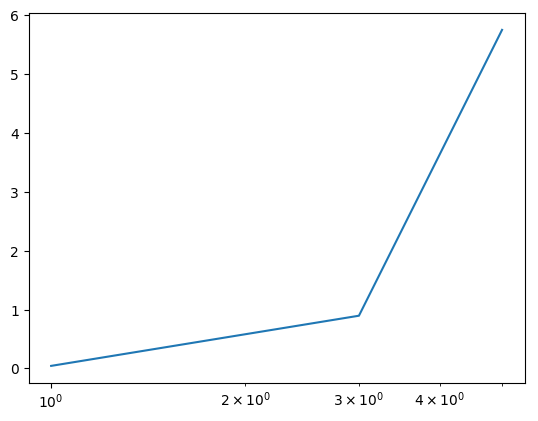

Academic license - for non-commercial use only
  5.855057 seconds (164 allocations: 24.550 MiB, 0.75% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003F8677B8>

In [53]:
using JuMP, Gurobi, PyPlot

scaleFactor = [1, 3, 5, 9, 15]
timer = zeros(length(scaleFactor))

for u=1:length(scaleFactor)

    
# Task/Worker Parameters
###############################

## We require 5 of task_1, 1 of task_2, etc.
N = [1,3,2]*scaleFactor[u]  #tasks
n = maximum(N) #max number of tasks for a category
v = size(N,1) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
#W = hcat(ones(w), 3*ones(w), 2*ones(w)) # 1 worker who completes task 1 in 1 time, tasks 2 in three time, etc.
W = [1 3 4;
     5 6 1;]
w = size(W,1) #number of workers


T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

###############################



m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=1:T-t], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
@expression(m, end_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t+W[i,k]) for t=1:T))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
@constraint(m, [j=1:n, k=1:v, i=1:w], last >= end_t[j,k,i])

@objective(m, Min, last)

    
    @time(solve(m))
    timer[u] = getsolvetime(m)

end

semilogx(scaleFactor,timer)

## Model 2 - Workers

Number of tasks and types of tasks held constant.  

Number of workers scales

Academic license - for non-commercial use only
  2.795056 seconds (164 allocations: 17.767 MiB, 0.78% gc time)
Academic license - for non-commercial use only
 10.956685 seconds (165 allocations: 52.105 MiB, 0.55% gc time)


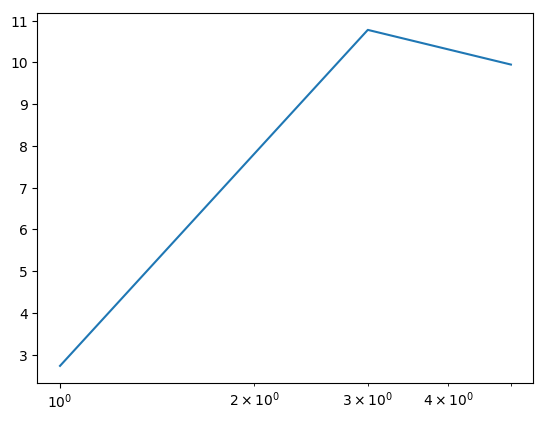

Academic license - for non-commercial use only
 10.181994 seconds (165 allocations: 63.790 MiB, 0.76% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003F9ACEF0>

In [58]:
using JuMP, Gurobi, PyPlot

scaleFactor = [1, 3, 5, 9, 15]
timer = zeros(length(scaleFactor))

for u=1:length(scaleFactor)

    
# Task/Worker Parameters
###############################

## We require 5 of task_1, 1 of task_2, etc.
N = [5,15,20] #tasks
n = maximum(N) #max number of tasks for a category
v = size(N,1) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
#W = hcat(ones(w), 3*ones(w), 2*ones(w)) # 1 worker who completes task 1 in 1 time, tasks 2 in three time, etc.
#W = [1 3 4;
#     5 6 1;]   
W = rand(1:10, 1*scaleFactor[u],3)
w = size(W,1) #number of workers


T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

###############################



m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=1:T-t], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
@expression(m, end_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t+W[i,k]) for t=1:T))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
@constraint(m, [j=1:n, k=1:v, i=1:w], last >= end_t[j,k,i])

@objective(m, Min, last)

    
    @time(solve(m))
    timer[u] = getsolvetime(m)

end

semilogx(scaleFactor,timer)

## Model 2 - Task Variety
Number of workers and tasks held constant.

Variety of task types scales


Academic license - for non-commercial use only
 44.417975 seconds (165 allocations: 163.488 MiB)
Academic license - for non-commercial use only
  0.909422 seconds (162 allocations: 14.230 MiB)


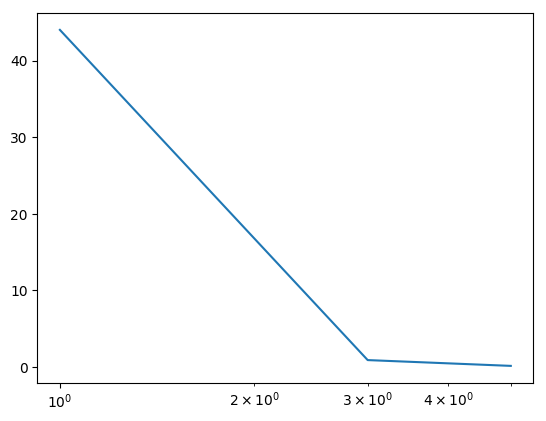

Academic license - for non-commercial use only
  0.131314 seconds (161 allocations: 4.504 MiB)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005158F8D0>

In [71]:
using JuMP, Gurobi, PyPlot

scaleFactor = [1, 3, 5, 9, 15]
timer = zeros(length(scaleFactor))

for u=1:length(scaleFactor)

    
# Task/Worker Parameters
###############################

## We require 5 of task_1, 1 of task_2, etc.
#N = [5,15,20] #tasks
N = round.(Int, 15/scaleFactor[u] * ones(1,scaleFactor[u])) #50 total tasks, normally, across categories
n = maximum(N) #max number of tasks for a category
v = size(N,1) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
W = rand(1:10, 5 ,3) # five workers, with skills across 3 categtories
w = size(W,1) #number of workers


T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

###############################



m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=1:T-t], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
@expression(m, end_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t+W[i,k]) for t=1:T))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
@constraint(m, [j=1:n, k=1:v, i=1:w], last >= end_t[j,k,i])

@objective(m, Min, last)

    
    @time(solve(m))
    timer[u] = getsolvetime(m)

end

semilogx(scaleFactor,timer)

## Model 2 - Task Variety, tasks number scales accordingly.
Number of workers constant

Variety of task types scales, and each task is done the same number of times.


Academic license - for non-commercial use only
  0.084780 seconds (160 allocations: 2.328 MiB)
Academic license - for non-commercial use only
  0.225876 seconds (162 allocations: 7.249 MiB)


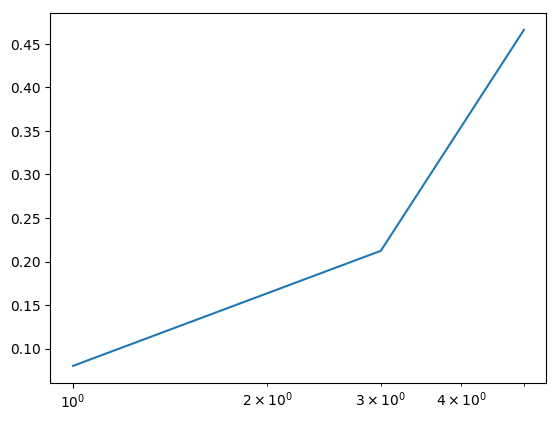

Academic license - for non-commercial use only
  0.492421 seconds (162 allocations: 12.709 MiB)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000050D5EFD0>

In [78]:
using JuMP, Gurobi, PyPlot

scaleFactor = [1, 3, 5, 9, 15]
timer = zeros(length(scaleFactor))

for u=1:length(scaleFactor)

    
# Task/Worker Parameters
###############################

## We require 5 of task_1, 1 of task_2, etc.
#N = [5,15,20] #tasks
N = round.(Int,10*ones(1,scaleFactor[u])) #50 total tasks, normally, across categories
n = maximum(N) #max number of tasks for a category
v = size(N,1) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
W = rand(1:10, 5 ,3) # five workers, with skills across 3 categtories
w = size(W,1) #number of workers


T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

###############################



m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=1:T-t], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
@expression(m, end_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t+W[i,k]) for t=1:T))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
@constraint(m, [j=1:n, k=1:v, i=1:w], last >= end_t[j,k,i])

@objective(m, Min, last)

    
    @time(solve(m))
    timer[u] = getsolvetime(m)

end

semilogx(scaleFactor,timer)